In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader
import seaborn
seaborn.set()
seaborn.set_style('ticks')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import sys
import fracdiff
from fracdiff import FracDiff, StationarityTester, StationaryFracDiff

## Coefficient

In [2]:
n_samples = 6

a = np.r_[1, np.zeros(n_samples - 1)]
a

array([1., 0., 0., 0., 0., 0.])

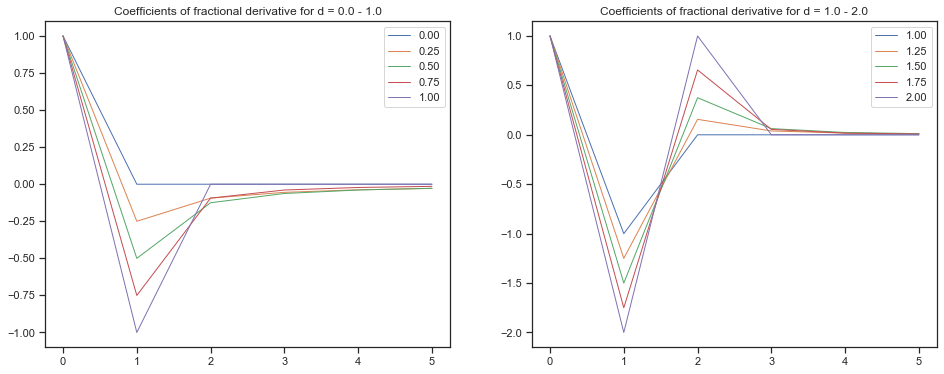

In [3]:
plt.figure(figsize=(16, 6))

def dict_a_d(lower, upper):
    return {
        order: FracDiff(order=order, window=-1).transform(a)
        for order in np.linspace(lower, upper, 5)
    }

title = 'Coefficients of fractional derivative for d = 0.0 - 1.0'
plt.subplot(1, 2, 1)
for order, a_d in dict_a_d(0.0, 1.0).items():
    plt.plot(a_d, label=f'{order:.2f}', linewidth=1)
plt.title(title)
plt.legend()

title = 'Coefficients of fractional derivative for d = 1.0 - 2.0'
plt.subplot(1, 2, 2)
for order, a_d in dict_a_d(1.0, 2.0).items():
    plt.plot(a_d, label=f'{order:.2f}', linewidth=1)
plt.title(title)
plt.legend()

plt.show()

## S&P 500

### Fetch data

In [4]:
series_spx = pandas_datareader.data.DataReader('^GSPC', 'yahoo', '1998-01-01', '2018-12-31')['Adj Close']

spx_dates = series_spx.index
spx = series_spx.values
logspx = np.log(spx)

series_spx

Date
1997-12-31     970.429993
1998-01-02     975.039978
1998-01-05     977.070007
1998-01-06     966.580017
1998-01-07     964.000000
                 ...     
2018-12-24    2351.100098
2018-12-26    2467.699951
2018-12-27    2488.830078
2018-12-28    2485.739990
2018-12-31    2506.850098
Name: Adj Close, Length: 5284, dtype: float64

### Fractional differentiation

In [5]:
order, window = 0.5, 1000

spx_d = FracDiff(order, window=window).transform(logspx)
series_spx_d = pd.Series(spx_d, index=spx_dates)

series_spx_d

Date
1997-12-31         NaN
1998-01-02         NaN
1998-01-05         NaN
1998-01-06         NaN
1998-01-07         NaN
                ...   
2018-12-24    0.080161
2018-12-26    0.147423
2018-12-27    0.138278
2018-12-28    0.130635
2018-12-31    0.138381
Length: 5284, dtype: float64

### Plot fractional differentiation with various orders

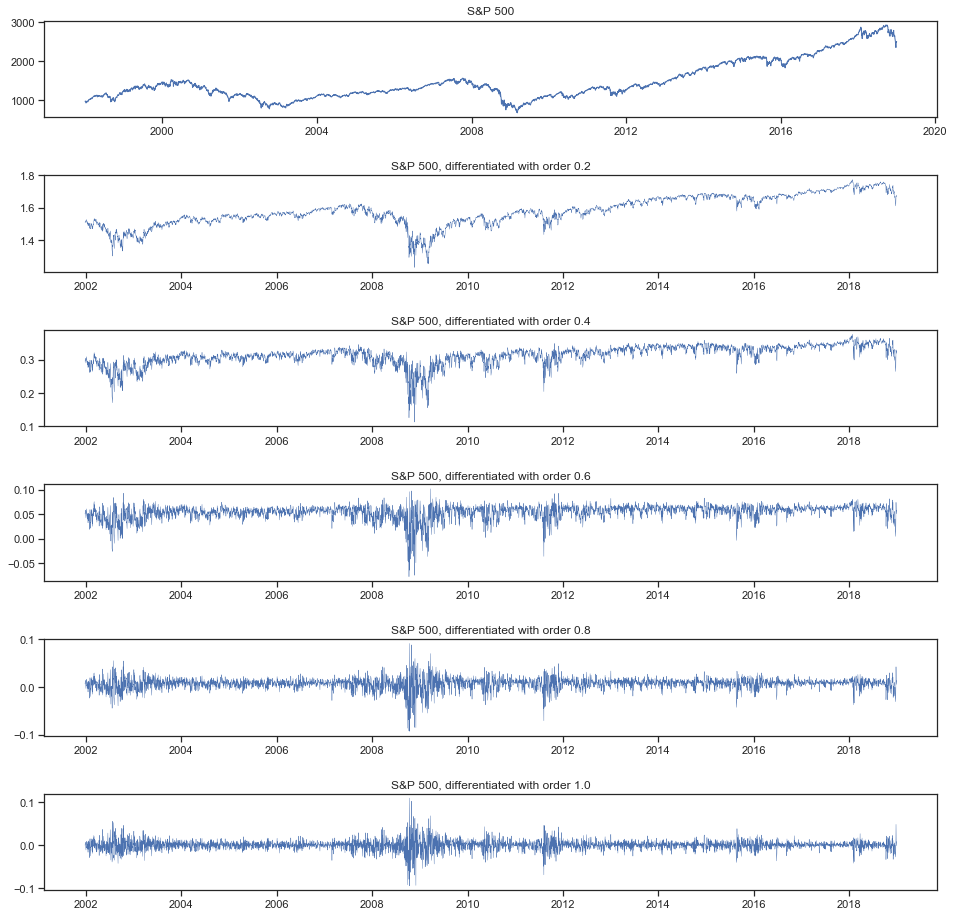

In [6]:
window = 1000

plt.figure(figsize=(16, 16))
plt.tight_layout()
plt.subplots_adjust(hspace=0.6)

plt.subplot(6, 1, 1)
plt.plot(series_spx, linewidth=1)
plt.title('S&P 500')

for i, order in enumerate(np.linspace(0.2, 1.0, 5)):
    spx_d = FracDiff(order, window=window).transform(logspx)
    series_spx_d = pd.Series(spx_d, index=spx_dates)
    plt.subplot(6, 1, 2 + i)
    plt.title(f'S&P 500, differentiated with order {order:.1f}')
    plt.plot(series_spx_d, linewidth=0.4)

plt.show()

### Stationarity of fractionally differentiated S&P 500

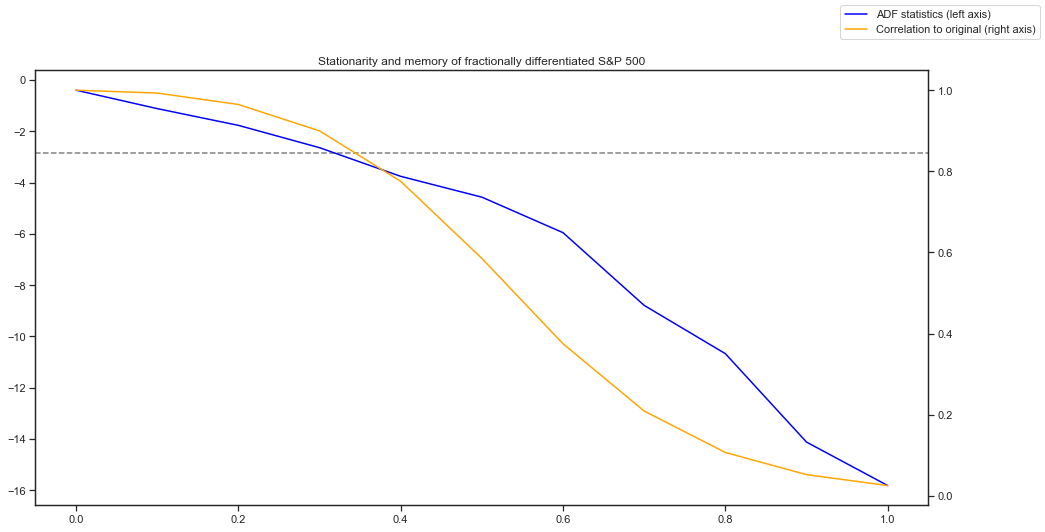

In [7]:
window = 1000

def adfstat(order):
    spx_d = FracDiff(order, window=window).transform(logspx)[window:]
    adf = StationarityTester().score(spx_d, value='statistics')
    return adf

def correlation(order):
    spx_d = FracDiff(order, window=window).transform(logspx)[window:]
    correlation = np.corrcoef(logspx[window:], spx_d)[0, 1]
    return correlation

# ADF statistics for orders in 0.0 - 1.0
orders = np.linspace(0.0, 1.0, 11)
adfstats = np.vectorize(adfstat)(orders)
correlations = np.vectorize(correlation)(orders)

# 5% critical value of stationarity
_, _, _, _, crit, _ = StationarityTester().score(logspx, value='all')
crit_5pc = crit['5%']

# plot
title = 'Stationarity and memory of fractionally differentiated S&P 500'
fig, ax_adf = plt.subplots(figsize=(16, 8))
ax_cor = ax_adf.twinx()

ax_adf.axhline(y=crit_5pc, linestyle='--', color='gray')
ax_adf.plot(orders, adfstats, color='blue', label='ADF statistics (left axis)')
ax_cor.plot(orders, correlations, color='orange', label='Correlation to original (right axis)')

plt.title(title)
fig.legend()
plt.show()

### Make time-series stationary by fractional differentiation

- Order: 0.33
- ADF p-value: 0.043


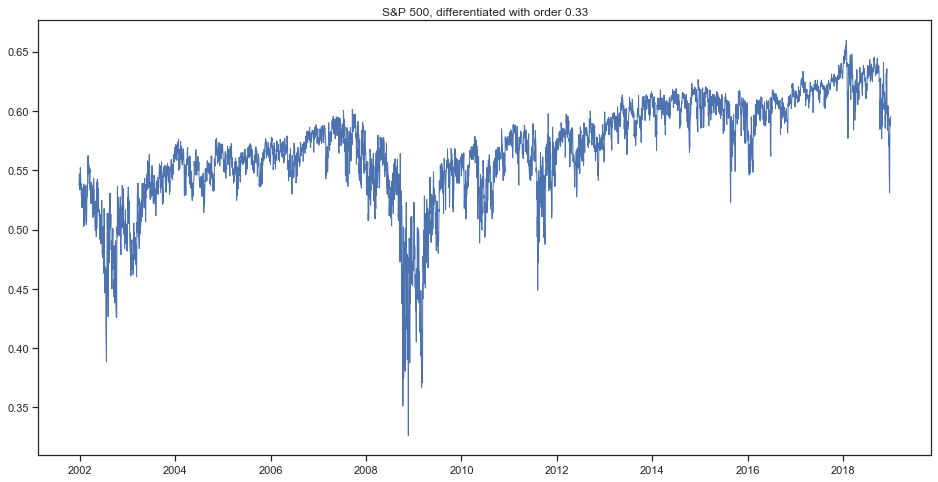

In [8]:
statfracdiff = StationaryFracDiff(window=1000, precision=.01)
stationarity = StationarityTester()

# fit and transform
spx_d = statfracdiff.fit_transform(logspx)
order = statfracdiff.order_
pvalue = stationarity.score(spx_d[window:])

print(f'- Order: {order:.2f}')
print(f'- ADF p-value: {pvalue:.3f}')

# Plot
title = f'S&P 500, differentiated with order {order:.2f}'
plt.figure(figsize=(16, 8))
plt.plot(pd.Series(spx_d, index=spx_dates), linewidth=1)
plt.title(title)
plt.show()

### Other financial data

In [9]:
tickers_yahoo = {
    'SPX': '^GSPC',
    'NKY': '^N225',
    'SHC': '^SSEC',
    'AAPL': 'AAPL',
}
tickers_fred = {
    'USDJPY': 'DEXJPUS',
    'GLD': 'GOLDPMGBD228NLBM',
    'OIL': 'DCOILWTICO',
}

prices_yahoo = pd.DataFrame({
    ticker: pandas_datareader.data.DataReader(symbol, 'yahoo', '1997-12-01', '2018-12-31')['Adj Close']
    for ticker, symbol in tickers_yahoo.items()
})
prices_fred = pd.DataFrame({
    ticker: pandas_datareader.data.DataReader(symbol, 'fred', '1997-12-01', '2018-12-31').iloc[:, 0]
    for ticker, symbol in tickers_fred.items()
})

prices = pd.concat([prices_yahoo, prices_fred], axis=1).fillna(method='ffill').loc['1998-01-02':]
logprices = prices.applymap(np.log)
logprices.head()

,SPX,NKY,SHC,AAPL,USDJPY,GLD,OIL
1998-01-02,6.882478,9.632908,7.085150,-0.683258,4.885828,5.662960,2.857045
1998-01-05,6.884558,9.612924,7.106994,-0.706605,4.897765,5.650382,2.830268
1998-01-06,6.873764,9.608875,7.117708,-0.530207,4.896944,5.644740,2.811809
1998-01-07,6.871091,9.617682,7.126143,-0.609150,4.880527,5.640488,2.827905
1998-01-08,6.862810,9.617083,7.120576,-0.570616,4.886507,5.640665,2.833801


In [10]:
orders = np.linspace(0.0, 1.0, 11)
window = 1000

def pvalues(logprice, orders):
    diffs = [
        FracDiff(order, window).transform(logprice.values)[window:]
        for order in orders
    ]
    return [StationarityTester().score(diff, value='statistics') for diff in diffs]

adfs = pd.DataFrame({
    ticker: pvalues(logprices[ticker], orders) for ticker in logprices.columns
}, index=orders)

adfs

,SPX,NKY,SHC,AAPL,USDJPY,GLD,OIL
0.0,-0.395448,-1.310900,-1.595408,-1.452211,-1.692604,-2.296187,-2.597027
0.1,-1.116486,-1.958071,-1.961442,-1.547842,-2.081515,-2.138786,-3.199101
0.2,-1.845781,-2.939938,-2.436154,-1.718673,-2.568227,-2.299444,-4.007230
0.3,-2.786410,-4.122739,-2.977327,-2.220688,-3.326647,-2.894744,-4.788055
0.4,-3.608038,-4.043312,-3.609823,-2.592133,-4.320820,-4.121218,-5.883332
0.5,-4.637848,-5.094946,-4.804972,-3.756349,-5.557501,-6.175087,-7.284331
0.6,-6.119738,-6.317738,-5.906422,-5.258399,-7.013097,-8.111972,-8.908492
0.7,-10.288455,-7.541480,-7.159559,-6.710914,-8.628676,-9.745739,-7.880795
0.8,-12.432966,-15.965919,-8.520352,-8.175393,-10.319628,-11.105507,-12.713785
0.9,-14.379831,-27.411063,-9.921755,-25.295307,-15.465352,-12.309734,-14.772753


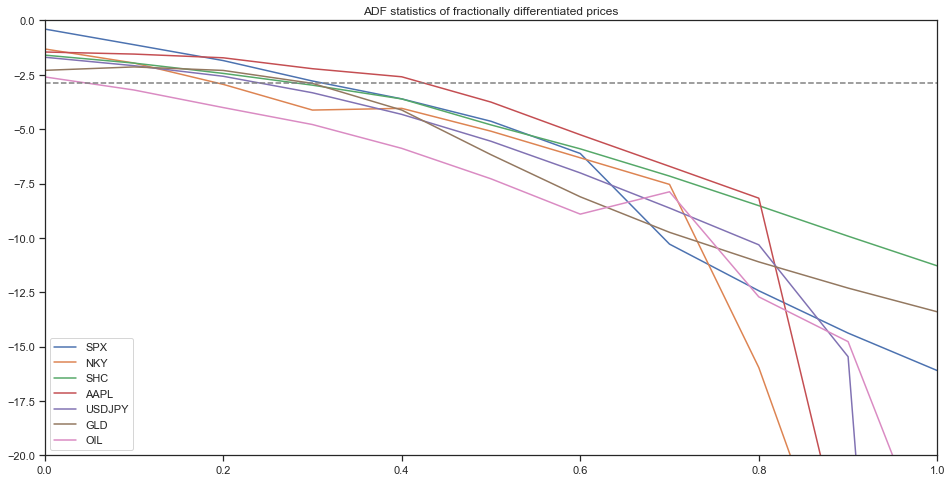

In [11]:
_, _, _, _, crit, _ = StationarityTester().score(logprices['SPX'].values, value='all')
crit_5pc = crit['5%']

title = 'ADF statistics of fractionally differentiated prices'
adfs.plot(figsize=(16, 8), ylim=(-20, 0))
plt.axhline(y=crit_5pc, linestyle='--', color='gray')
plt.title(title)
plt.show()